# Testing Mixture Distribution Networks

In [2]:
import matplotlib.pyplot as plt
import numpy as np
import edward as ed
import tensorflow as tf
from edward.models import Categorical, Mixture, Normal
import math

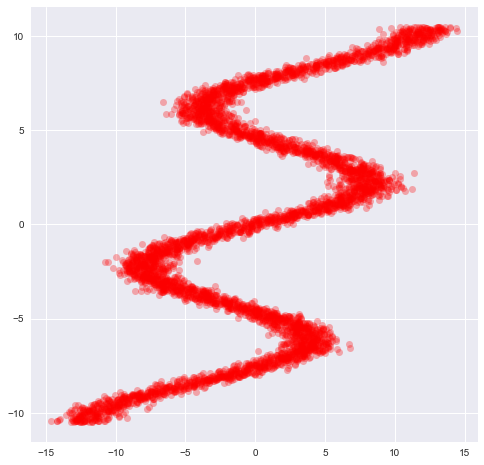

In [27]:
## Generating some data:

NSAMPLE = 5000

y_data = np.float32(np.random.uniform(-10.5, 10.5, NSAMPLE))
r_data = np.random.normal(size=NSAMPLE)
x_data = np.sin(0.75 * y_data) * 7.0 + y_data * 0.5 + r_data * 1.0
x_data = x_data.reshape((NSAMPLE, 1))

plt.figure(figsize=(8, 8))
plt.plot(x_data,y_data,'ro', alpha=0.3)
plt.show()

In [28]:
## MDN
NHIDDEN = 24
STDEV = 0.5
KMIX = 24 # number of mixtures
NOUT = KMIX * 3 # pi, mu, stdev

x = tf.placeholder(dtype=tf.float32, shape=[None,1], name="x")
y = tf.placeholder(dtype=tf.float32, shape=[None], name="y")

def fully_connected_network(X):
    Wh = tf.Variable(tf.random_normal([1,NHIDDEN], stddev=STDEV, dtype=tf.float32))
    bh = tf.Variable(tf.random_normal([1,NHIDDEN], stddev=STDEV, dtype=tf.float32))
    
    Wo = tf.Variable(tf.random_normal([NHIDDEN,NOUT], stddev=STDEV, dtype=tf.float32))
    bo = tf.Variable(tf.random_normal([1,NOUT], stddev=STDEV, dtype=tf.float32))
    
    hidden_layer = tf.nn.tanh(tf.matmul(x, Wh) + bh)
    output = tf.matmul(hidden_layer,Wo) + bo
    return output

def split_tensor_to_mixture_parameters(output):
  logits = tf.placeholder(dtype=tf.float32, shape=[None,KMIX], name="mixparam")
  scales = tf.placeholder(dtype=tf.float32, shape=[None,KMIX], name="mixparam")
  locs = tf.placeholder(dtype=tf.float32, shape=[None,KMIX], name="mixparam")
  # Split up the output nodes into three groups for Pis, Sigmas and Mus.
  logits, scales, locs = tf.split(value=output, num_or_size_splits=3,axis=1)
  # Transform the sigmas to e^sigma
  scales = tf.exp(scales)
  return logits, scales, locs

output = fully_connected_network(x)
logits, scales, locs = split_tensor_to_mixture_parameters(output)

cat = Categorical(logits=logits)
coll = [Normal(loc=loc, scale=scale) for loc, scale
              in zip(tf.unstack(tf.transpose(locs)),
                     tf.unstack(tf.transpose(scales)))]
mixture = Mixture(cat=cat, components=coll, value=tf.zeros_like(y))

inference = ed.MAP(data={mixture: y})
inference.initialize(var_list=tf.trainable_variables())
sample = mixture.sample()

In [29]:
inference.initialize(var_list=tf.trainable_variables())

sess = ed.get_session()
tf.global_variables_initializer().run()

In [30]:
n_epoch = 6000
train_loss = np.zeros(n_epoch)
for i in range(n_epoch):
  info_dict = inference.update(feed_dict={x: x_data, y: y_data})
  train_loss[i] = info_dict['loss']
  inference.print_progress(info_dict)

1000/1000 [100%] ██████████████████████████████ Elapsed: 21s | Loss: 7797.175

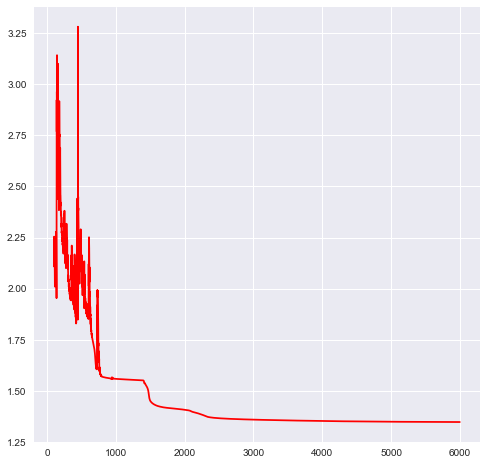

In [31]:
plt.figure(figsize=(8, 8))
plt.plot(np.arange(100, n_epoch,1), train_loss[100:]/NSAMPLE, 'r-')
plt.savefig('mdn-training-loss-'+str(n_epoch)+'epochs.pdf', dpi=150, format="pdf")
plt.show()

In [ ]:
## Tests on individual runs.

sess.close()

sess = tf.InteractiveSession()
sess.run(tf.global_variables_initializer())

#sess.run(train_op,feed_dict={x: x_data, y: y_data})
#sample_output = sess.run(sample, feed_dict={x:x_data})
#sess.run(loss, feed_dict={x: x_data, y: y_data})

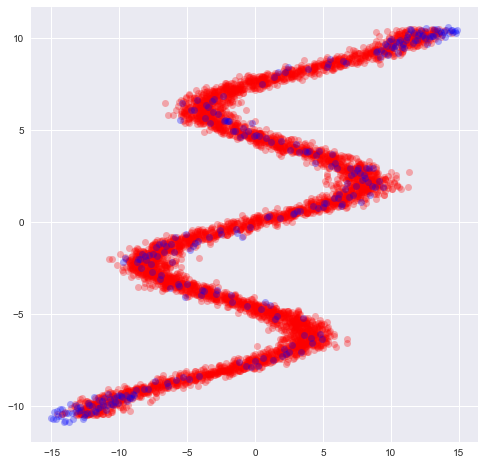

In [32]:
## Sample on some test data:

x_test = np.float32(np.arange(-15,15,0.1))
NTEST = x_test.size
x_test = x_test.reshape(NTEST,1) # needs to be a matrix, not a vector
y_test = sess.run(sample, feed_dict={x:x_test})

plt.figure(figsize=(8, 8))
plt.plot(x_data,y_data,'ro', x_test,y_test,'bo',alpha=0.3)
plt.savefig('mdn-output-'+str(n_epoch)+'epochs.pdf', dpi=150, format="pdf")
plt.show()

In [ ]:
## Sample on some test data:

x_test = np.float32(np.arange(-15,15,0.1))
NTEST = x_test.size
x_test = x_test.reshape(NTEST,1) # needs to be a matrix, not a vector

#x_test.shape

sess.run()

#plt.figure(figsize=(8, 8))
#plt.plot(x_data,y_data,'ro', x_test,y_test,'bo',alpha=0.3)
#plt.show()

# plt.figure(figsize=(8, 8))
# plt.plot(x_test,out_mu_test,'go', x_test,y_test,'bo',alpha=0.3)
# plt.show()